In [20]:
# imports
import os
import sys
sys.path.append("../")
import numpy as np
from functions_EDX import *
from VCA import *
import time
import matplotlib.pyplot as plt
from scipy.optimize import nnls 
from datetime import datetime
from matplotlib import cm
import cv2
import random
import tifffile as tf
from pysptools.material_count.vd import HfcVd
from PIL import Image
import matplotlib as mpl
import matplotlib.patches as patches
import hyperspy.api as hs

### MPL settings

In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'

# this one makes the ticks into text in the exported svgs
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

### Xray lines from hyperspy

In [76]:
xray_energies = np.load('../../secondary_data/xray_energies.npz')['xray_energies']

# define elements to plot, their x-ray lines and find the respective energy (in keV)
xray_lines = [
    ['C', 'Ka'],
    ['N', 'Ka'],
    ['O', 'Ka'],
    ['P', 'Ka'],
    ['S', 'Ka'],
    ['Cl', 'Ka'],
    ['Ca', 'Ka'],
    ['Cu', 'Ka'],
    ['Cu', 'La'],
    ['Al', 'Ka'],
    ['Fe', 'Ka'],
    ['Fe', 'La'],
    ['Os', 'Ma'],
    ['Os', 'La'],
    ['Cd', 'La'],
    ['Sn', 'La'],
    ['Zn', 'La']
]

for idx, xray in enumerate(xray_lines):
    xray_lines[idx].append(hs.material.elements[xray[0]].Atomic_properties.Xray_lines[xray[1]]['energy (keV)'])
print(xray_lines)

[['C', 'Ka', 0.2774], ['N', 'Ka', 0.3924], ['O', 'Ka', 0.5249], ['P', 'Ka', 2.0133], ['S', 'Ka', 2.3072], ['Cl', 'Ka', 2.6224], ['Ca', 'Ka', 3.6917], ['Cu', 'Ka', 8.0478], ['Cu', 'La', 0.9295], ['Al', 'Ka', 1.4865], ['Fe', 'Ka', 6.4039], ['Fe', 'La', 0.7045], ['Os', 'Ma', 1.9138], ['Os', 'La', 8.9108], ['Cd', 'La', 3.1338], ['Sn', 'La', 3.444], ['Zn', 'La', 1.0116]]


## Convenient things

In [4]:
res_xy = 1024
xray_energies_dir = '../../secondary_data/xray_energies.npz'
xray_energies = np.load(xray_energies_dir)['xray_energies']

## Choose a tile and load preprocessed data

In [6]:
tile_idx = 0

spectrum_folder = '../../../primary_data/qdot_mosaic/Spectrum2D/pca06/'
file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]

spectrum_2D = np.load(files[tile_idx])['spectrum_2D']


npz_folder = '../../../primary_data/qdot_mosaic/NPZ'
file_names = []
tmp = os.listdir(npz_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(npz_folder,file_name) for file_name in file_names]

haadf = rebin_XY(np.load(files[tile_idx])['haadf'],1024)
#haadf = (haadf*255).astype('uint8')

### Estimated number of endmembers

In [8]:
nEM_est = HfcVd(spectrum_2D)
print(nEM_est)

[7, 7, 7]


### VCA

In [15]:
np.random.seed(100); endmember_spectra, vca_idx, Yp = vca(spectrum_2D.transpose(),7,verbose=True)

SNR estimated = nan[dB]
... Select the projective proj.


## Plot the endmember spectra

(0.0, 20.0)

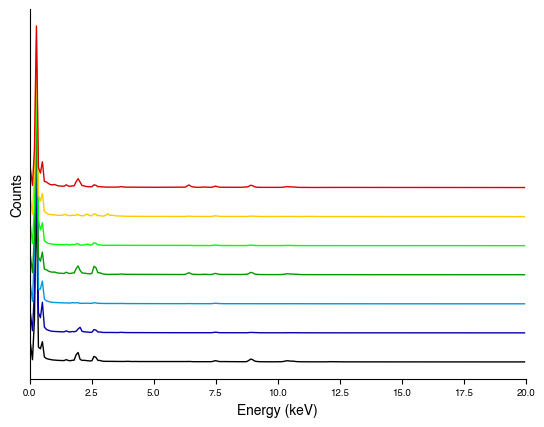

In [16]:
%matplotlib inline
# offset, plot and save all endmember spectra
endmember_spectra_offset = np.copy(endmember_spectra)
endmember_spectra_offset = (endmember_spectra_offset - np.min(endmember_spectra_offset))/(np.max(endmember_spectra_offset) - np.min(endmember_spectra_offset))

seperation_interval = 1/endmember_spectra_offset.shape[1]
for i in range(endmember_spectra_offset.shape[1]):
    endmember_spectra_offset[:,i] += (i*seperation_interval)

    
cmap = plt.get_cmap('nipy_spectral')
cmap_idx = np.linspace(0, 0.9, endmember_spectra_offset.shape[1])

f, ax = plt.subplots()
for i in range(endmember_spectra_offset.shape[1]):
    ax.plot(xray_energies, 
            endmember_spectra_offset[:,i], 
            color = list(cmap(cmap_idx[i])), 
            linewidth = 1)

ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('Energy (keV)')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0,20)
#plt.savefig('../png/figure_2Spectra_new.svg')

## Unmixing with nnls

In [17]:
start = datetime.now()
abundance_maps = np.array([nnls(endmember_spectra,i)[0] for i in spectrum_2D]).transpose()
end = datetime.now()
print('Duration: {}'.format(end - start))

Duration: 0:00:21.355101


## Visualize abundance maps

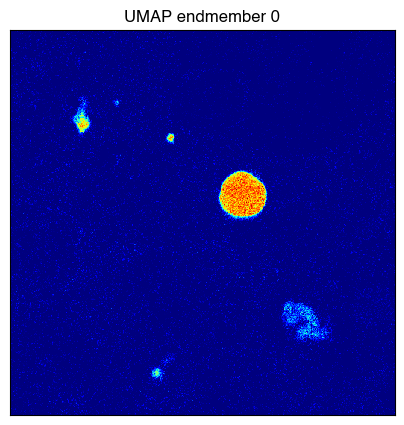

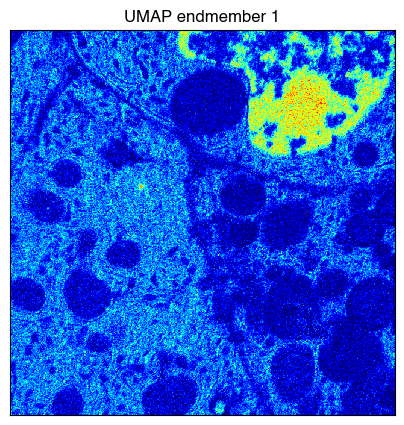

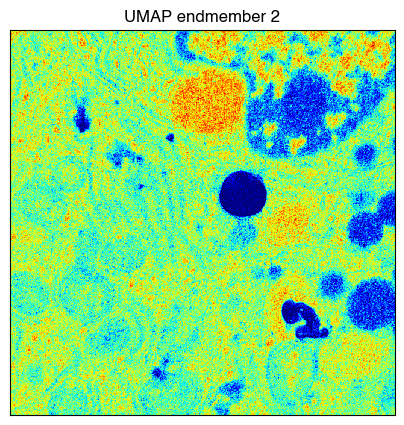

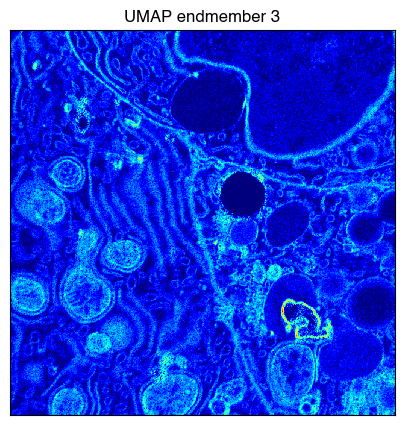

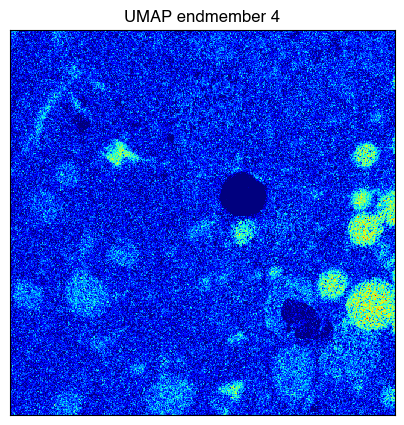

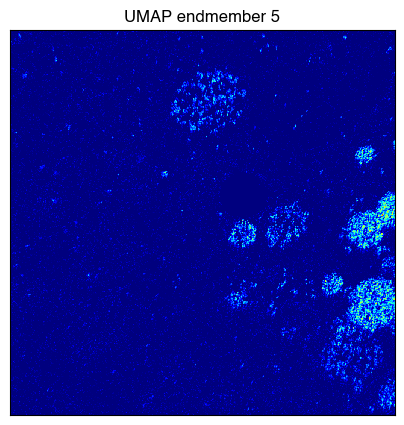

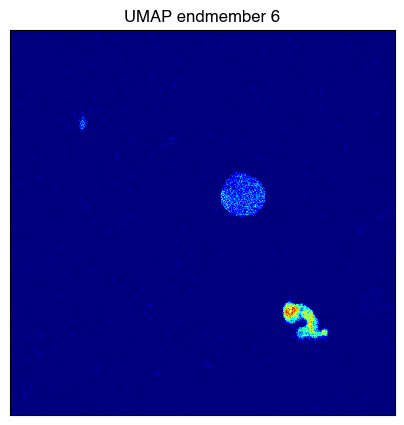

In [18]:
%matplotlib inline 
abundance_maps = np.reshape(abundance_maps,(np.shape(abundance_maps)[0],res_xy,res_xy))
abundance_maps = nnls_maxcf(abundance_maps)
cmap = 'jet'

for ends in range(np.shape(abundance_maps)[0]):
    fig, ax = plt.subplots(figsize=(5,5))    
    ax.imshow(abundance_maps[ends], interpolation='nearest',cmap=cmap, vmin = 0)
    ax.set_title('UMAP endmember ' + str(ends))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #im = Image.fromarray(255-(abundance_maps[ends]*255).astype('uint8'))
    #im.save("../../secondary_data/Figure2_abundancemaps/%02d.png" % ends)
    plt.show()



### Visualize closly (beta)

In [ ]:
cmap = 'jet'
em1 = 5
fig,ax = plt.subplots(2,3,figsize=(20,20))
thresh = 0

# crop rectangle
x,y,w,l = 420,80,220,220
rect1 = patches.Rectangle((x, y), w, l, linewidth=1, edgecolor='k', facecolor='none')
rect2 = patches.Rectangle((x, y), w, l, linewidth=1, edgecolor='k', facecolor='none')
rect3 = patches.Rectangle((x, y), w, l, linewidth=1, edgecolor='k', facecolor='none')

ax[0][0].imshow(normalize8(haadf), interpolation='nearest',cmap='gray_r', vmin = 0)
ax[0][0].set_title('EM image')
ax[0][0].axes.get_xaxis().set_visible(False)
ax[0][0].axes.get_yaxis().set_visible(False)
ax[0][0].add_patch(rect1)

ax[0][1].imshow(normalize8(spectrum_2D[:,39].reshape((res_xy,res_xy))), interpolation='nearest',cmap='gray_r', vmin = 0)
ax[0][1].set_title('Cadmium map')
ax[0][1].axes.get_xaxis().set_visible(False)
ax[0][1].axes.get_yaxis().set_visible(False)
ax[0][1].add_patch(rect2)

ax[0][2].imshow(normalize8(abundance_maps[em1]), interpolation='nearest',cmap='gray_r', vmin = 0)
ax[0][2].set_title('Spectral signature map')
ax[0][2].axes.get_xaxis().set_visible(False)
ax[0][2].axes.get_yaxis().set_visible(False)
ax[0][2].add_patch(rect3)




# Thresholded
ax[1][0].imshow(normalize8(haadf)[y:y+l,x:x+w], interpolation='nearest',cmap='gray_r', vmin =thresh)
#ax[1][0].set_title('Haadf')
ax[1][0].axes.get_xaxis().set_visible(False)
ax[1][0].axes.get_yaxis().set_visible(False)

ax[1][1].imshow(normalize8(spectrum_2D[:,39].reshape((res_xy,res_xy)))[y:y+l,x:x+w], interpolation='nearest',cmap='gray_r', vmin=thresh)
#ax[1][1].set_title('Cadmium')
ax[1][1].axes.get_xaxis().set_visible(False)
ax[1][1].axes.get_yaxis().set_visible(False)

ax[1][2].imshow(normalize8(abundance_maps[em1])[y:y+l,x:x+w], interpolation='nearest',cmap='gray_r', vmin = thresh)
#ax[1][2].set_title('VCA ' + str(2))
ax[1][2].axes.get_xaxis().set_visible(False)
ax[1][2].axes.get_yaxis().set_visible(False)



plt.tight_layout()
plt.show()
#plt.savefig('../../svg/figure_4_vcaQdot.svg')

### plot the spectrum of the qdot endmember

In [77]:
# set xticks and add vertical lines at selected xray_lines
xticks = []
xlabels = []
xlim = 7

# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    xticks.append(np.argmin(np.abs(xray_energies-xray[2])))
    if xray[1] == 'Ka':
        xlabels.append(xray[0])
    else:
        xlabels.append(xray[0] + ' ' + xray[1])

print(xticks)
print(xlabels)

[3, 4, 6, 25, 28, 32, 46, 100, 11, 18, 80, 8, 23, 111, 39, 43, 12]
['C', 'N', 'O', 'P', 'S', 'Cl', 'Ca', 'Cu', 'Cu La', 'Al', 'Fe', 'Fe La', 'Os Ma', 'Os La', 'Cd La', 'Sn La', 'Zn La']


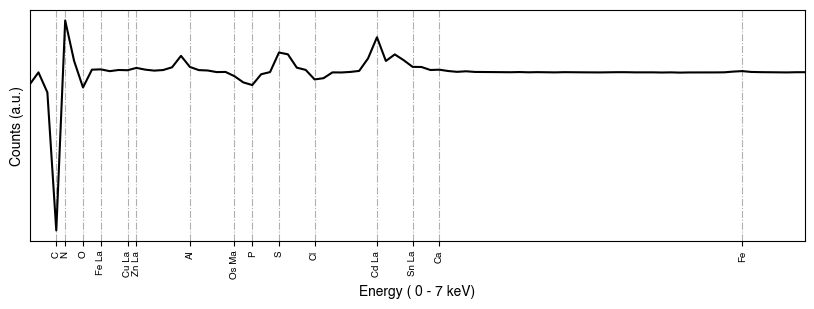

In [78]:
# set yticks
xlim = [0,7]
offset = 0.2

# plot
fig,ax = plt.subplots(figsize=(10,3))
#ax.plot(range(250),endmember_spectra[:,em1]/np.max(endmember_spectra[:,em1]),c='k')
ax.plot(range(250),(endmember_spectra[:,em1]-spectrum_2D.mean(axis=0))/np.max(endmember_spectra[:,em1])+offset,c='k') #linestyle='dashdot')
ax.set_xticks(xticks, xlabels, rotation = 90, size = 7)
ax.set_xlabel('Energy ( 0 - ' + str(xlim[1]) + ' keV)')
ax.set_xlim([np.argmin(np.abs(xray_energies-xlim[0])),np.argmin(np.abs(xray_energies-xlim[1]))])
ax.set_yticks([], [], size = 10)
ax.set_ylabel('Counts (a.u.)')
plt.grid('On',linestyle='dashdot')
plt.show()
#plt.savefig('../svg/figure_4_spectrumDifference.svg')